<a href="https://colab.research.google.com/github/eruru0411/git-test/blob/master/LH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## install / import / def

### 글꼴 설치

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (5,101 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 160975 files and d

### import : for modeling
- MyChartPlotHistory(history)
- tensorflow, pandas, numpy, matplotlib, seaborn, keras

In [ ]:
# from keras.datasets import fashion_mnist
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from keras.utils  import to_categorical
from keras.preprocessing.image import ImageDataGenerator, load_img    # keras 이미지 전처리를 위한 클래스

# (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data() 는 tensorflow에 있는 데이터로만 가능
import os           # dir 읽어서 올림
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10)

import warnings
warnings.filterwarnings(action="ignore")

np.random.seed(121)
tf.random.set_seed(121)

In [ ]:
def MyChartPlotHistory(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],    label='acc')
    plt.plot(hist['epoch'], hist['val_accuracy'],label = 'val_acc')
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(hist['epoch'], hist['loss'],    label = 'loss')
    plt.plot(hist['epoch'], hist['val_loss'],label = 'val_loss')
    plt.legend()
    plt.show()

### import: for map
- install pydeck, mip, geopandas
- sharply, geopandas

In [ ]:
pip install geoplot

In [ ]:
pip install pydeck

In [ ]:
pip install mip

In [ ]:
pip install geopandas

In [ ]:
import pathlib
import random
from functools import reduce
from collections import defaultdict

# import pandas as pd
import geopandas as gpd
import folium
import shapely
import fiona
# import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import sklearn.cluster
# import tensorflow as tf

#from geoband import API

import pydeck as pdk
import os

import cufflinks as cf 
cf.go_offline(connected=True)
cf.set_config_file(theme='polar')

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
# plt.rcParams["font.family"] = 'Nanum Gothic'
plt.rc('font', family='NanumBarunGothic') 

from shapely.geometry import Polygon, Point
from numpy import random

#최적화 solver
import time
from mip import Model, xsum, maximize, BINARY  

In [ ]:
#Pydeck 사용을 위한 함수 정의
import geopandas as gpd 
import shapely # Shapely 형태의 데이터를 받아 내부 좌표들을 List안에 반환합니다. 
def line_string_to_coordinates(line_string): 
    if isinstance(line_string, shapely.geometry.linestring.LineString): 
        lon, lat = line_string.xy 
        return [[x, y] for x, y in zip(lon, lat)] 
    elif isinstance(line_string, shapely.geometry.multilinestring.MultiLineString): 
        ret = [] 
        for i in range(len(line_string)): 
            lon, lat = line_string[i].xy 
            for x, y in zip(lon, lat): 
                ret.append([x, y])
        return ret 

def multipolygon_to_coordinates(x): 
    lon, lat = x[0].exterior.xy 
    return [[x, y] for x, y in zip(lon, lat)] 

def polygon_to_coordinates(x): 
    lon, lat = x.exterior.xy 
    return [[x, y] for x, y in zip(lon, lat)] 

In [ ]:
def geo_to_df(df_whatwillread, na_col=None, norm_col=None, geotype='multipolygon'):

    # 격자별 인구 현황
    # df_08= gpd.read_file("../../data/GY/input/08.광양시_격자별인구현황(100X100).geojson")  --> df
    df_08 = df_whatwillread

    # val 열 na 제거
    if na_col != None:
      df_08[na_col] = df_08[na_col].fillna(0)


    # 인구 수 정규화
    if norm_col != None:
      df_08['정규화'] = df_08[norm_col] / df_08[norm_col].max()

    # geotype == 'multipolygon'
    if geotype == 'multipolygon':
      # geometry를 coordinate 형태로 적용
      df_08['coordinates'] = df_08['geometry'].apply(multipolygon_to_coordinates) #pydeck 을 위한 coordinate type
    elif geotype == 'multilinestring':
      df_08['coordinates'] = df_08['geometry'].apply(line_string_to_coordinates) 
    elif geotype == 'polygon':
      df_08['coordinates'] = df_08['geometry'].apply(polygon_to_coordinates)
    elif geotype == 'multipoint':
      df_08['coordinates'] = df_08['geometry'].apply(multipoint_to_coordinates)        

    # 100X100 grid에서 central point 찾기
    df_08_list = []
    df_08_list2 = []
    for i in df_08['geometry']:
        cent = [[i[0].centroid.coords[0][0],i[0].centroid.coords[0][1]]]
        df_08_list.append(cent)
        df_08_list2.append(Point(cent[0]))
    df_08['coord_cent'] = 0
    df_08['geo_cent'] = 0
    df_08['coord_cent']= pd.DataFrame(df_08_list) # pydeck을 위한 coordinate type
    df_08['geo_cent'] = df_08_list2               # geopandas를 위한 geometry type


    # 쉬운 분석을 위한 임의의 grid id 부여
    df_08['grid_id']=0
    idx = []
    for i in range(len(df_08)):
        idx.append(str(i).zfill(5))
    df_08['grid_id'] = pd.DataFrame(idx)

In [ ]:
# for gpd plot
def gpdplot(dataframe, gpd_col, title="", show=True, cmap='YlGnBu_r', sub=False, nrow=None, ncol=None, figsize=(5, 5)):
    if sub == True:
        count=0
        fig, axes = plt.subplots(nrow, ncol, figsize=figsize)
        for r in range(nrow):
            if count > len(dataframe): break
            for c in range(ncol):
                if count >= len(dataframe): break
                ax = dataframe[count].plot(column=gpd_col[count], cmap=cmap, ax=axes[r,c])
                ax.set_title(title[count], fontsize=20)
                ax.set_axis_off()
                count += 1
                            
    else:
        ax = dataframe.plot(column=gpd_col, cmap=cmap, figsize=figsize)
        ax.set_title(title, fontsize=20)
        ax.set_axis_off()
    if show == True:
        plt.show()

## Data

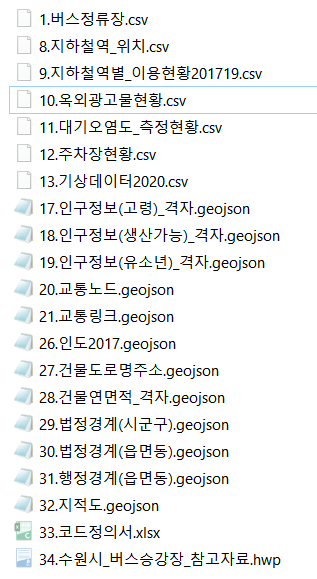
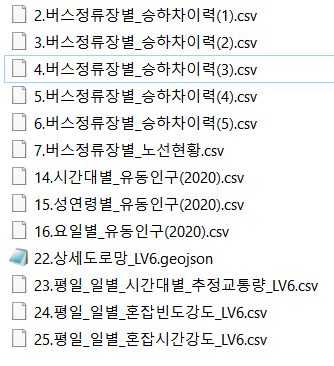

요일별 생략 가능 -> 시간대별 데이터 나눠서 사용


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
colab_path = '/content/drive/MyDrive/Colab Notebooks/data/LH/'
# colab_path = '/content/drive/MyDrive/data/LH/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### csv

In [ ]:
df_버정 = pd.read_csv(colab_path + '1.버스정류장_mod(utf-8).csv', usecols=['정류장ID', '쉘터', 'BIS설치여부', 'lon', 'lat'])
df_버정.head()

,정류장ID,쉘터,BIS설치여부,lon,lat
0,201000313,1.0,1.0,126.970983,37.256983
1,201000345,NaN,1.0,127.016000,37.251091
2,201000379,NaN,1.0,126.953845,37.268806
3,201000055,NaN,1.0,127.029815,37.256755
4,201000268,1.0,1.0,127.034254,37.246081


In [ ]:
df_버정 = df_버정.fillna(0)
df_BIS = df_버정[df_버정['BIS설치여부'] == 1.0]
df_BIS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 928 entries, 0 to 927
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   정류장ID    928 non-null    int64  
 1   쉘터       928 non-null    float64
 2   BIS설치여부  928 non-null    float64
 3   lon      928 non-null    float64
 4   lat      928 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 43.5 KB


#### <b>df_대기오염도</b>: 11.대기오염도_측정현황.csv
- 시각화: folium - 법정시군구별, 버스 정류장, 미세먼지 top 10

In [ ]:
df_대기오염도 = pd.read_csv(colab_path + "11.대기오염도_측정현황_mod(utf-8).csv")
df_대기오염도.info()

#설치전 null값 -> 0으로 처리
df_대기오염도 = df_대기오염도.fillna(0)
df_대기오염도

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   구분          192 non-null    object 
 1   측정연도        192 non-null    int64  
 2   측정월         192 non-null    int64  
 3   측정소         192 non-null    object 
 4   미세먼지        189 non-null    float64
 5   초미세먼지       189 non-null    float64
 6   오존          189 non-null    float64
 7   이산화질소       189 non-null    float64
 8   아황산가스(ppm)  189 non-null    float64
 9   일산화탄소       189 non-null    float64
 10  lon         192 non-null    float64
 11  lat         192 non-null    float64
dtypes: float64(8), int64(2), object(2)
memory usage: 18.1+ KB


,구분,측정연도,측정월,측정소,미세먼지,초미세먼지,오존,이산화질소,아황산가스(ppm),일산화탄소,lon,lat
0,도시대기,2019,1,고색동,62.0,41.0,0.010,0.042,0.005,0.8,126.976384,37.252329
1,도시대기,2019,2,고색동,55.0,36.0,0.015,0.037,0.004,0.7,126.976384,37.252329
2,도시대기,2019,3,고색동,66.0,47.0,0.024,0.033,0.004,0.7,126.976384,37.252329
3,도시대기,2019,4,고색동,36.0,19.0,0.029,0.030,0.003,0.5,126.976384,37.252329
4,도시대기,2019,5,고색동,43.0,25.0,0.041,0.025,0.004,0.5,126.976384,37.252329
...,...,...,...,...,...,...,...,...,...,...,...,...
187,도시대기,2020,8,호매실동,27.0,16.0,0.016,0.014,0.002,0.5,126.957008,37.266153
188,도시대기,2020,9,호매실동,21.0,12.0,0.026,0.018,0.002,0.5,126.957008,37.266153
189,도시대기,2020,10,호매실동,38.0,17.0,0.018,0.028,0.003,0.5,126.957008,37.266153
190,도시대기,2020,11,호매실동,46.0,28.0,0.012,0.034,0.003,0.5,126.957008,37.266153


In [ ]:
def 미세먼지_drop(미세먼지):
  if   미세먼지 <= 30:  cate = "좋음"
  elif 미세먼지 <= 80:  cate = "보통"
  elif 미세먼지 <= 150: cate = "나쁨"
  else:                 cate = "매우나쁨"
  return cate

def 초미세먼지_drop(초미세먼지):
  if   초미세먼지 <= 15: cate = "좋음"
  elif 초미세먼지 <= 50: cate = "보통"
  elif 초미세먼지 <= 100: cate = "나쁨"
  else:           cate = "매우나쁨"
  return cate

df_대기오염도["미세먼지정도"]   = df_대기오염도["미세먼지"].apply(lambda x: 미세먼지_drop(x))
df_대기오염도["초미세먼지정도"] = df_대기오염도["초미세먼지"].apply(lambda x: 초미세먼지_drop(x))

df_대기오염도.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   구분          192 non-null    object 
 1   측정연도        192 non-null    int64  
 2   측정월         192 non-null    int64  
 3   측정소         192 non-null    object 
 4   미세먼지        192 non-null    float64
 5   초미세먼지       192 non-null    float64
 6   오존          192 non-null    float64
 7   이산화질소       192 non-null    float64
 8   아황산가스(ppm)  192 non-null    float64
 9   일산화탄소       192 non-null    float64
 10  lon         192 non-null    float64
 11  lat         192 non-null    float64
 12  미세먼지정도      192 non-null    object 
 13  초미세먼지정도     192 non-null    object 
dtypes: float64(8), int64(2), object(4)
memory usage: 21.1+ KB


In [ ]:
df_대기오염도 = df_대기오염도.sort_values(by='초미세먼지', ascending=False)
df_대기오염도 = df_대기오염도.sort_values(by='미세먼지'  , ascending=False)

df_대기오염도_worst = df_대기오염도[:10]
df_대기오염도_worst

,구분,측정연도,측정월,측정소,미세먼지,초미세먼지,오존,이산화질소,아황산가스(ppm),일산화탄소,lon,lat,미세먼지정도,초미세먼지정도
50,도로변,2019,3,동수원,89.0,54.0,0.018,0.047,0.004,0.8,127.030494,37.276744,나쁨,나쁨
48,도로변,2019,1,동수원,83.0,45.0,0.006,0.050,0.004,1.1,127.030494,37.276744,나쁨,보통
49,도로변,2019,2,동수원,74.0,43.0,0.010,0.050,0.004,0.9,127.030494,37.276744,보통,보통
146,도시대기,2019,3,천천동,73.0,49.0,0.027,0.031,0.003,0.6,126.975305,37.292877,보통,보통
122,도시대기,2019,3,인계동,71.0,50.0,0.026,0.034,0.003,0.7,127.028723,37.263637,보통,보통
98,도시대기,2019,3,영통동,71.0,41.0,0.027,0.036,0.003,0.7,127.056294,37.246901,보통,보통
26,도시대기,2019,3,광교동,70.0,46.0,0.024,0.037,0.004,0.6,127.070615,37.291321,보통,보통
120,도시대기,2019,1,인계동,68.0,42.0,0.013,0.043,0.004,0.9,127.028723,37.263637,보통,보통
144,도시대기,2019,1,천천동,68.0,39.0,0.012,0.042,0.004,0.7,126.975305,37.292877,보통,보통
96,도시대기,2019,1,영통동,68.0,23.0,0.010,0.046,0.003,0.9,127.056294,37.246901,보통,보통


In [ ]:
center = (37.27505, 127.0094448)
zoom = 12

s_map = folium.Map(location=center, zoom_start=zoom, attr='수원시',
                   tiles='http://api.vworld.kr/req/wmts/1.0.0/C475A102-4BC0-3992-8A8F-D9241A7B2094/Base/{z}/{y}/{x}.png')

folium.GeoJson(df_법정시군구29).add_to(s_map)

NameError: ignored

In [ ]:
for index, row in df_대기오염도.iterrows():
    folium.Marker([row['lat'], row['lon']], icon=folium.Icon(color='red', icon='star')).add_to(s_map)

from folium.plugins import MarkerCluster, MiniMap
mc = MarkerCluster()

for row in df_BIS.itertuples():
    mc.add_child(folium.Marker(location = [row.lat, row.lon], popup = row.정류장명)).add_to(s_map)
    #s_map.add_child(mc)
# s

s_map

## From COMPAS

### input parameter type - 실행X(참고용)


type name|Description
-|-	
feature_name|feature 명. <br>공간연산에 필요한 feature 목록을 compas에서 제공합니다.<br>feature_name에는 반드시 compas에서 제공된 목록에 있는 feature 명만 사용 가능합니다.
feature_list|feture 이름 List.<br>공간연산시 여러 개의 feature가 필요한 경우 콤마(,)를 구분자로 해서 feature_list를 API에 제공해야 합니다.
cql|	Casandra Query Languate
GeoJSON|	위치정보를 갖는 점을 기반으로 체계적으로 지형을 표현하기 위해 설계된 개방형 공개 표준 형식.
boolean	|True / False

4  Sample Featrues Data
Geoband 에서 제공하는 Feature 데이타 입니다. 공간분석시 사용가능합니다.
API 호출시 Feature Name을 사용하시기 바랍니다.

Type	|Title	|Feature Name	|SRS
-|-|-|-
Polygon	|시도	|geoband:tl_scco_ctprvn	|EPSG:4326
Polygon	|시군구	|geoband:tl_scco_sig	|EPSG:4326
Polygon	|리	|geoband:tl_scco_li	|EPSG:4326
Polygon	|읍면동	|geoband:tl_scco_emd	|EPSG:4326
Point	|녹시율(부산)	|geoband:gvi_busan	|EPSG:4326
Point	|녹시율(대구)	|geoband:gvi_daegu	|EPSG:4326
Point	|녹시율(광주)	|geoband:gvi_gwangju	|EPSG:4326
Point	|녹시율(화성)	|geoband:gvi_hwaseong	|EPSG:4326
Point	|녹시율(인천)	|geoband:gvi_incheon	|EPSG:4326
Point	|녹시율(세종)	|geoband:gvi_sejong	|EPSG:4326
Point	|녹시율(서울)	|geoband:gvi_seoul	|EPSG:4326
Point	|녹시율(울산)	|geoband:gvi_ulsan	|EPSG:4326
Point	|서울시 아파트	|geoband:apartment	|EPSG:4326
Point	|전국 은행	|geoband:bank	|EPSG:4326
Point	|전국 버거킹	|geoband:bugerking	|EPSG:4326
Point	|전국 던킨도너츠	|geoband:dunkindonuts	|EPSG:4326
Point	|전국 지진	|geoband:earthquake	|EPSG:3857
Polygon	|서울시 동	|geoband:emd	|EPSG:3857
Point	|전국 대기업	|geoband:enterprise	|EPSG:3857
Point	|전국 소방서	|geoband:firestation	|EPSG:3857
Point	|서울시 가스충전소	|geoband:gasstation	|EPSG:3857
Point	|전국 골프장	|geoband:golf	|EPSG:3857
Point	|서울시 병원	|geoband:hospital	|EPSG:3857
Point	|전국 KFC	|geoband:kfc	|EPSG:3857
Polygon	|전국 읍면동	|geoband:korea_emd	|EPSG:3857
Point	|전국 학교	|geoband:korea_school	|EPSG:3857
Polygon	|전국 시군구	|geoband:korea_sgg	|EPSG:3857
Line	|서울시 샘플 라인	|geoband:line	|EPSG:3857
Point	|전국 롯데리아	|geoband:lotteria	|EPSG:3857
Point	|서울시 재래시장	|geoband:market	|EPSG:3857
Point	|전국 맥도널드	|geoband:mcdonalds	|EPSG:3857
Point	|전국 아웃브레이크	|geoband:outbreak	|EPSG:3857
Line	|서울시 OD 데이터	|geoband:od_flow	|EPSG:3857
Polygon	|서울시 오버레이1	|geoband:overlay01	|EPSG:3857
Polygon	|서울시 오버레이2	|geoband:overlay02	|EPSG:3857
Point	|서울시 주점	|geoband:pubs	|EPSG:3857
Line	|서울시 도로망	|geoband:road	|EPSG:3857
Polygon	|서울 구별 인구 변화	|geoband:seoul_series	|EPSG:3857
Point	|서울시 학교	|geoband:school	|EPSG:3857
Polygon	|서울시 구	|geoband:sgg	|EPSG:3857
Polygon	|서울시 경계	|geoband:sid	|EPSG:3857
Point	|전국 철도역	|geoband:stations	|EPSG:3857
Point	|서울시 마트	|geoband:stores	|EPSG:3857
Point	|서울시 극장	|geoband:theaters	|EPSG:3857
Line	|전국 지하철노선	|geoband:subway	|EPSG:3857
Point	|서울시 위험 화학물 취급업소	|geoband:toxic_office	|EPSG:3857
Point	|서울시 추적점	|geoband:track_points	|EPSG:3857
Point	|서울시 구청	|geoband:wardoffice	|EPSG:3857

In [ ]:
from geoband.API import *

ModuleNotFoundError: ignored

### EDA

####  <b>geojson</b> 풀기 for pydeck - type : multipolygon, multilinestring, multipoints
- 도로명27, 지적도32, 행정읍면동31, 법정시군구29, 법정읍면동30, 교통노드20, 교통링크21, 건물연면적28, 인도26
- 상세도로망22(비공개)

dataframe | type | ncols |columns 
-|-|-|-
df_교통노드20|multipoint|6|<b>NODE_ID</b>/ NODE_TYPE/ NODE_NAME/ TURN_P/ REMARK/ geometry
df_교통링크21|multilinestring|17|<b>LINK_ID</b>/ F_NODE/ T_NODE/ ROAD_USE/ LANES/ ROAD_RANK/ ROAD_NAME/ MULTI_LINK/ CONNECT/ MAX_SPD/ REST_VEH/ REST_W/ REST_H/ REMARK/ ROAD_TYPE/ ROAD_NO/<br> geometry/ coordinates/ coord_cent/ geo_cent/ grid_id
df_인도26| multilinestring | 6 |<b>UFID</b>/ WIDT/ QUAL/ BYYN/ KIND/ geometry/ coordinates/ coord_cent/ geo_cent/ grid_id
df_도로명27|multipolygon|11|<b>BDTYP_CD</b>/ BULD_NM/ BULD_NM_DC/ BULD_SE_CD/ BUL_MAN_NO/ EMD_CD/ GRO_FLO_CO/ LNBR_MNNM/ LNBR_SLNO/ UND_FLO_CO/ <br>geometry/ coordinates/ coord_cent/ geo_cent/ grid_id
df_연면적28|multipolygon|3|<b>gid</b>/ val/ geometry/ 정규화/ coordinates/ coord_cent/ geo_cent/ grid_id
df_법정시군구29|multipolygon|3|<b>SIG_CD</b>/ SIG_KOR_NM/ geometry/ coordinates/ coord_cent/ geo_cent/ grid_id
df_법정읍면동30|multipolygon|3|<b>EMD_CD</b>/ EMD_KOR_NM/ geometry/ coordinates/ coord_cent/ geo_cent/ grid_id
df_행정읍면동31|multipolygon|3|<b>ADM_DR_CD</b>/ ADM_DR_NM/ geometry/ coordinates/ coord_cent/ geo_cent/ grid_id
df_지적도32|multipolygon|3|<b>PNU</b>/ JIBUN/ geometry/ coordinates/ coord_cent/ geo_cent/ grid_id
|<b>비공개 데이터</b>||
df_상세도로망22| multilinestring| 19 |<b>link_id</b>/ max_speed/ road_name/ road_no/ road_rank/ link_type/ road_type/ facil_name/ up_lanes/ dw_lanes/ oneway/ length/ width/ car_lane/ num_cross/ barrier/ up_its_id/ dw_its_id/ <br>geometry/ coordinates/ coord_cent/ geo_cent/ grid_id


In [ ]:
df_교통노드20   = gpd.read_file(colab_path + '20.교통노드.geojson', encoding='utf-8')
df_교통링크21   = gpd.read_file(colab_path + '21.교통링크.geojson', encoding='utf-8')
df_인도26       = gpd.read_file(colab_path + '26.인도2017.geojson', encoding='utf-8')
df_도로명27     = gpd.read_file(colab_path + '27.건물도로명주소.geojson', encoding='utf-8')
df_연면적28     = gpd.read_file(colab_path + '28.건물연면적_격자.geojson', encoding='utf-8')
df_법정시군구29 = gpd.read_file(colab_path + '29.법정경계(시군구).geojson', encoding='utf-8')
df_법정읍면동30 = gpd.read_file(colab_path + '30.법정경계(읍면동).geojson', encoding='utf-8')
df_행정읍면동31 = gpd.read_file(colab_path + '31.행정경계(읍면동).geojson', encoding='utf-8')
df_지적도32     = gpd.read_file(colab_path + '32.지적도.geojson', encoding='utf-8')
df_상세도로망22 = gpd.read_file(colab_path + '22.상세도로망_LV6.geojson', encoding='utf-8')

In [ ]:
# df_교통노드20.head()      # REMARK - null / col 6 / multipoint        
# df_교통링크21.head()      # REMARK, REST_VEH - null / col 17 -> REST_VEH na_col / multilinestring
# df_인도26.head()          # col 6 / multilinestring                   
# df_도로명27.head()        # BULD_NM, BULD_NM_DC - null / col 11 / multipolygon   
# df_연면적28.head()        # val(격자 내 건물 연면적) - null / col 3 -> val na_col, norm / multipolygon
# df_법정시군구29.head()    # col 3 / multipolygon
# df_법정읍면동30.head()    # col 3 / multipolygon
# df_행정읍면동31.head()    # col 3 / multipolygon
# df_지적도32.head()        # col 3 / multipolygon
# df_상세도로망22.head()    # road_name, facil_name - null / col 19 / multilinestring

In [ ]:
# type: multipolygon
geo_to_df(df_도로명27)
geo_to_df(df_연면적28, na_col='val', norm_col='val')
geo_to_df(df_법정시군구29)
geo_to_df(df_법정읍면동30)
geo_to_df(df_행정읍면동31)
geo_to_df(df_지적도32)

In [ ]:
# type: multilinestring
geo_to_df(df_교통링크21, geotype='multilinestring')    # multilinestring
geo_to_df(df_상세도로망22, geotype='multilinestring')  # multilinestring
geo_to_df(df_인도26, geotype='multilinestring')        # multilinestring
# geo_to_df(df_교통노드20)    # multipoint

In [ ]:
df_가능인도 = df_인도26[df_인도26['WIDT']>= 1.5]
df_가능인도.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5076 entries, 3 to 6649
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   UFID         5076 non-null   object  
 1   WIDT         5076 non-null   float64 
 2   QUAL         5076 non-null   object  
 3   BYYN         5076 non-null   object  
 4   KIND         5076 non-null   object  
 5   geometry     5076 non-null   geometry
 6   coordinates  5076 non-null   object  
 7   coord_cent   5076 non-null   object  
 8   geo_cent     5076 non-null   object  
 9   grid_id      5076 non-null   object  
dtypes: float64(1), geometry(1), object(8)
memory usage: 436.2+ KB


#### <b>df_지적도32</b>: 도로, 공장, 학교, 주차장, 유원지, 체육시설

In [ ]:
df_지적도32.head()

,PNU,JIBUN,geometry,coordinates,coord_cent,geo_cent,grid_id
0,4111710300101670003,167-3전,"MULTIPOLYGON (((127.05529 37.28866, 127.05533 ...","[[127.05528958143441, 37.2886637490931], [127....","[127.05547584284302, 37.288664233630406]",POINT (127.055475842843 37.28866423363041),00000
1,4111113800101980001,198-1전,"MULTIPOLYGON (((127.01543 37.32614, 127.01547 ...","[[127.01542984431295, 37.32613895945019], [127...","[127.0154508779549, 37.32608379742076]",POINT (127.0154508779549 37.32608379742076),00001
2,4111710300201190028,산119-28임,"MULTIPOLYGON (((127.05120 37.28951, 127.05120 ...","[[127.05120312136171, 37.28950604393701], [127...","[127.05114793605217, 37.28938244343387]",POINT (127.0511479360522 37.28938244343387),00002
3,4111710300109070001,907-1잡,"MULTIPOLYGON (((127.03676 37.29320, 127.03723 ...","[[127.03676458675396, 37.29319598101757], [127...","[127.03752564377774, 37.2935264620074]",POINT (127.0375256437777 37.2935264620074),00003
4,4111710300101770017,177-17임,"MULTIPOLYGON (((127.05132 37.28945, 127.05170 ...","[[127.05131698711158, 37.28945310556074], [127...","[127.05144254811702, 37.28933850350089]",POINT (127.051442548117 37.28933850350089),00004


In [ ]:
for idx in range(df_지적도32.shape[0]):
    df_지적도32['JIBUN'][idx] = df_지적도32['JIBUN'][idx][-1]

df_지적도32.head(3)

,PNU,JIBUN,geometry,coordinates,coord_cent,geo_cent,grid_id
0,4111710300101670003,전,"MULTIPOLYGON (((127.05529 37.28866, 127.05533 ...","[[127.05528958143441, 37.2886637490931], [127....","[127.05547584284302, 37.288664233630406]",POINT (127.055475842843 37.28866423363041),00000
1,4111113800101980001,전,"MULTIPOLYGON (((127.01543 37.32614, 127.01547 ...","[[127.01542984431295, 37.32613895945019], [127...","[127.0154508779549, 37.32608379742076]",POINT (127.0154508779549 37.32608379742076),00001
2,4111710300201190028,임,"MULTIPOLYGON (((127.05120 37.28951, 127.05120 ...","[[127.05120312136171, 37.28950604393701], [127...","[127.05114793605217, 37.28938244343387]",POINT (127.0511479360522 37.28938244343387),00002


In [ ]:
df_지적도32['JIBUN'].unique()

array(['전', '임', '잡', '도', '대', '답', '공', '천', '과', '구', '학', '창', '종',
       '차', '철', '묘', '장', '목', '유', '주', '수', '사', '체', '제', '가', '양',
       '2', '원'], dtype=object)

In [ ]:
jibun = ['도','장','학','차','원','체']
df_지적도32 = df_지적도32[df_지적도32['JIBUN'].isin(jibun)]
df_지적도32.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 28844 entries, 5 to 128834
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PNU          28844 non-null  object  
 1   JIBUN        28844 non-null  object  
 2   geometry     28844 non-null  geometry
 3   coordinates  28844 non-null  object  
 4   coord_cent   28844 non-null  object  
 5   geo_cent     28844 non-null  object  
 6   grid_id      28844 non-null  object  
dtypes: geometry(1), object(6)
memory usage: 1.8+ MB


#### <b>merge_버정</b>: df_승하차이력 + df_버정
- <b>df_승하차이력</b>: 버스정류장별 승하차이력(비공개, 2.~6.)
- <b>df_버정</b>: 1.버스정류장 정보
- <b>df_노선현황7</b>: 7.버스정류장별_노선현황(비공개)

In [ ]:
df_1 = pd.read_csv(colab_path + '2.버스정류장별_승하차이력(1).csv', encoding='utf-8')
df_2 = pd.read_csv(colab_path + '3.버스정류장별_승하차이력(2).csv', encoding='utf-8')
df_3 = pd.read_csv(colab_path + '4.버스정류장별_승하차이력(3).csv', encoding='utf-8')
df_4 = pd.read_csv(colab_path + '5.버스정류장별_승하차이력(4).csv', encoding='utf-8')
df_5 = pd.read_csv(colab_path + '6.버스정류장별_승하차이력(5).csv', encoding='utf-8')

In [ ]:
df_승하차이력 = df_1.append(df_2)
df_승하차이력 = df_승하차이력.append(df_3)
df_승하차이력 = df_승하차이력.append(df_4)
df_승하차이력 = df_승하차이력.append(df_5)

In [ ]:
df_승하차이력['전체 승차 건수'] = df_승하차이력['전체 승차 건수'].astype(np.int32)
df_승하차이력['초승 건수']      = df_승하차이력['초승 건수'].astype(np.int32)
df_승하차이력['환승 건수']      = df_승하차이력['환승 건수'].astype(np.int32)
df_승하차이력['전체 하차 건수'] = df_승하차이력['전체 하차 건수'].astype(np.int32)
df_승하차이력['하차 건수']      = df_승하차이력['하차 건수'].astype(np.int32)
df_승하차이력['미태그 건수']    = df_승하차이력['미태그 건수'].astype(np.int32)

In [ ]:
df_승하차이력.drop('정류소명', axis=1, inplace=True)
df_승하차이력.drop('업체명', axis=1, inplace=True)

In [ ]:
def busbus(bus):
    num = 0
    if   bus == '직행좌석형시내버스': num = 0
    elif bus == '일반형시내버스': num = 1
    elif bus == '경기순환버스(직행좌석형)' : num = 2
    elif bus == '광역급행형시내버스' : num = 3
    elif bus == '좌석형시내버스' : num = 4
    else: num = 5       # '맞춤형시내버스
    return num

In [ ]:
df_승하차이력['노선유형'] = df_승하차이력['노선유형'].apply(lambda x : busbus(x))

In [ ]:
features = ['정류소ID', '전체 승차 건수', '초승 건수', '환승 건수', '전체 하차 건수', '하차 건수', '미태그 건수']
df_승하차 = df_승하차이력[features].groupby('정류소ID').agg(sum) 

df_승하차.reset_index(inplace=True)

In [ ]:
승하차_col = {'정류소ID':'정류장ID', '전체 승차 건수':'전체승차', '초승 건수': '초승', '환승 건수':'환승', '전체 하차 건수':'전체하차', '하차 건수': '하차'}
df_승하차.rename(columns = 승하차_col, inplace = True)
# df_승하차.head()

In [ ]:
merge_버정 = df_승하차.merge(df_버정, on='정류장ID', how="outer")

버정_col = ['정류장ID', '전체승차', '초승', '환승', '전체하차', '하차', '쉘터', 'BIS설치여부', 'lon', 'lat']
merge_버정 = merge_버정[버정_col]
merge_버정.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1179 entries, 0 to 1178
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   정류장ID    1179 non-null   int64  
 1   전체승차     1114 non-null   float64
 2   초승       1114 non-null   float64
 3   환승       1114 non-null   float64
 4   전체하차     1114 non-null   float64
 5   하차       1114 non-null   float64
 6   쉘터       781 non-null    float64
 7   BIS설치여부  928 non-null    float64
 8   lon      1179 non-null   float64
 9   lat      1179 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 101.3 KB


In [ ]:
# na값 채우기
merge_버정 = merge_버정.fillna(0)

# type 변경(float -> int)
for s in range(1, 8):
    merge_버정[merge_버정.columns[s]] = merge_버정[merge_버정.columns[s]].astype(np.int32)
merge_버정.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1179 entries, 0 to 1178
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   정류장ID    1179 non-null   int64  
 1   전체승차     1179 non-null   int32  
 2   초승       1179 non-null   int32  
 3   환승       1179 non-null   int32  
 4   전체하차     1179 non-null   int32  
 5   하차       1179 non-null   int32  
 6   쉘터       1179 non-null   int32  
 7   BIS설치여부  1179 non-null   int32  
 8   lon      1179 non-null   float64
 9   lat      1179 non-null   float64
dtypes: float64(2), int32(7), int64(1)
memory usage: 69.1 KB


In [ ]:
# df_승하차이력['정류소ID'].nunique()     # 1114
# df_승하차이력['일자'].nunique()         # 2020-01-01 ~ 2020-12-31
# df_승하차이력['노선번호'].nunique()     # 156

In [ ]:
df_노선현황7 = pd.read_csv(colab_path + '7.버스정류장별_노선현황.csv')

노선_rename_col = {'정류소ID':'정류장ID', '중앙차로여부':'중앙차로노변', '위치(동)':'동'}
df_노선현황7.rename(columns = 노선_rename_col, inplace=True)

df_노선현황7 = df_노선현황7[['정류장ID', '중앙차로노변', '동']]

In [ ]:
df_노선현황7.head()

,정류장ID,중앙차로노변,동
0,200000001,노변정류장,경기도 수원시 연무동
1,200000002,노변정류장,경기도 수원시 연무동
2,200000003,노변정류장,경기도 수원시 연무동
3,200000004,노변정류장,경기도 수원시 연무동
4,200000005,노변정류장,경기도 수원시 연무동


In [ ]:
merge_버정 = merge_버정.merge(df_노선현황7, on='정류장ID', how="outer")
merge_버정.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1179 entries, 0 to 1178
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   정류장ID    1179 non-null   int64  
 1   전체승차     1179 non-null   int32  
 2   초승       1179 non-null   int32  
 3   환승       1179 non-null   int32  
 4   전체하차     1179 non-null   int32  
 5   하차       1179 non-null   int32  
 6   쉘터       1179 non-null   int32  
 7   BIS설치여부  1179 non-null   int32  
 8   lon      1179 non-null   float64
 9   lat      1179 non-null   float64
 10  중앙차로노변   1128 non-null   object 
 11  동        1128 non-null   object 
dtypes: float64(2), int32(7), int64(1), object(2)
memory usage: 87.5+ KB


In [ ]:
merge_버정['동'] = merge_버정.동.str.split('경기도 수원시 ').str[1]
merge_버정.head()

,정류장ID,전체승차,초승,환승,전체하차,하차,쉘터,BIS설치여부,lon,lat,중앙차로노변,동
0,200000001,533,529,4,3664,3664,0,0,127.016928,37.317630,노변정류장,연무동
1,200000002,978,971,7,18901,18901,0,0,127.019208,37.315958,노변정류장,연무동
2,200000003,2224,2180,44,10218,10218,0,0,127.021054,37.313257,노변정류장,연무동
3,200000004,3221,3087,134,14821,14821,0,0,127.027748,37.309108,노변정류장,연무동
4,200000005,9386,7970,1416,72860,72860,1,1,127.031546,37.301462,노변정류장,연무동


In [ ]:
merge_버정['중앙차로노변'] = merge_버정['중앙차로노변'].apply(lambda x: 0 if x == '노변정류장' else 1)
merge_버정.head()

,정류장ID,전체승차,초승,환승,전체하차,하차,쉘터,BIS설치여부,lon,lat,중앙차로노변,동
0,200000001,533,529,4,3664,3664,0,0,127.016928,37.317630,0,연무동
1,200000002,978,971,7,18901,18901,0,0,127.019208,37.315958,0,연무동
2,200000003,2224,2180,44,10218,10218,0,0,127.021054,37.313257,0,연무동
3,200000004,3221,3087,134,14821,14821,0,0,127.027748,37.309108,0,연무동
4,200000005,9386,7970,1416,72860,72860,1,1,127.031546,37.301462,0,연무동


##### 되나 보자... contains! within!

In [ ]:
# merge_버정 위치 좌표
mg_버정 = []
for mg in range(merge_버정.shape[0]):
    temp = []
    temp = [merge_버정['lon'][mg], merge_버정['lat'][mg]]
    mg_버정.append(temp)

In [ ]:
# 행정읍면동 위경도
center_point = {}
for idx in range(df_행정읍면동31.shape[0]):
    center_point[df_행정읍면동31['ADM_DR_NM'][idx]] = df_행정읍면동31['coord_cent'][idx]

In [ ]:
from math import sqrt
def get_distance(array1, array2):
    return sqrt((array1[0] - array2[0]) ** 2 + (array1[1] - array2[1]) ** 2)

def src_to_ctr(search_point, map_point):      # mg_버정 인덱스 숫자
    search_list = []
    for idx, sp in enumerate(search_point):   # 1179
        dist = {}
        dist_list = {}
        search = {}
        for mp in range(len(map_point)):      # 44
            if len(dist) > 0:
                if min(sorted(list(dist.values()))) > get_distance(search_point[idx], list(center_point.values())[mp]):
                    dist[list(map_point.keys())[mp]] = get_distance(search_point[idx], list(map_point.values())[mp])
                    search[list(map_point.keys())[mp]] = {"dist_gap":dist[list(map_point.keys())[mp]], "정류장위치":search_point[mp]}
            else: 
                dist[list(map_point.keys())[mp]] = get_distance(search_point[idx], list(map_point.values())[mp])
                search[list(map_point.keys())[mp]] = {"dist_gap":dist[list(map_point.keys())[mp]], "정류장위치":search_point[mp]}
        dist_list[idx] = [search]
        search_list.append(dist_list)
    return search_list

In [ ]:
src_list = src_to_ctr(mg_버정, center_point)
src_list[2]
# {2: [{'송죽동': 0.017620597279945947,
#    '연무동': 0.011546766545263142,
#    '정자2동': 0.03089267515984762,
#    '조원2동': 0.009081584111907352,
#    '파장동': 0.03250053355866013}]}

{2: [{'송죽동': {'dist_gap': 0.017620597279945947,
    '정류장위치': [127.0315459, 37.3014618]},
   '연무동': {'dist_gap': 0.011546766545263142,
    '정류장위치': [127.0294636, 37.30001394]},
   '정자2동': {'dist_gap': 0.03089267515984762,
    '정류장위치': [127.02774769999999, 37.30910832]},
   '조원2동': {'dist_gap': 0.009081584111907352,
    '정류장위치': [127.0276999, 37.30894625]},
   '파장동': {'dist_gap': 0.03250053355866013,
    '정류장위치': [127.0169284, 37.31762986]}}]}

In [ ]:
# if src_list key값(동) == df_행정읍면동31['ADM_DR_NM'] --> df_행정읍면동31['geometry'] 가 src_list '정류장위치'를 포함하는지 확인
# 포함한다면 해당하는 동 이름을 merge_버정에 올려줌
def _check_exist_in_region(point_x, point_y, data_jeju):
    point = Point(point_x, point_y)
    found = False
    for i in range(len(data_jeju['features'])):
        feature = data_jeju['features'][i]
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            region = feature['properties']['EMD_NM']
            found = True
    if not found:
        return found, ''
    return found, region

#### <b>공간확보</b>

In [ ]:
df_인도26.head()        # data 6650
# df_인도26.info()

,UFID,WIDT,QUAL,BYYN,KIND,geometry,coordinates,coord_cent,geo_cent,grid_id
0,1000037612070A00310000000000154767,0.0,SWQ001,BYC001,SWK002,"MULTILINESTRING ((126.98492 37.32861, 126.9849...","[[126.98492477104054, 37.32861429173025], [126...","[126.98531218123986, 37.32792748308081]",POINT (126.9853121812399 37.32792748308081),00000
1,1000037612070A00310000000000154768,0.0,SWQ001,BYC001,SWK002,"MULTILINESTRING ((126.98567 37.32644, 126.9857...","[[126.98567135163154, 37.32643671936139], [126...","[126.98585074591097, 37.32599428890625]",POINT (126.985850745911 37.32599428890625),00001
2,1000037612070A00310000000000154769,0.0,SWQ001,BYC001,SWK002,"MULTILINESTRING ((126.98459 37.32839, 126.9849...","[[126.98458621654031, 37.32839471386689], [126...","[126.98512716061825, 37.32743384409757]",POINT (126.9851271606182 37.32743384409757),00002
3,1000037612070A00310000000000154793,3.0,SWQ003,BYC001,SWK001,"MULTILINESTRING ((126.98565 37.32643, 126.9856...","[[126.98565272370675, 37.326431994479215], [12...","[126.98590013961238, 37.32588752109277]",POINT (126.9859001396124 37.32588752109277),00003
4,1000037612070A00310000000000154794,3.0,SWQ003,BYC001,SWK001,"MULTILINESTRING ((126.98461 37.32840, 126.9847...","[[126.98460747532971, 37.32840442338037], [126...","[126.98515362362919, 37.32742528209013]",POINT (126.9851536236292 37.32742528209013),00004


In [ ]:
df_BIS.head()

,정류장ID,쉘터,BIS설치여부,lon,lat
0,201000313,1.0,1.0,126.970983,37.256983
1,201000345,0.0,1.0,127.016000,37.251091
2,201000379,0.0,1.0,126.953845,37.268806
3,201000055,0.0,1.0,127.029815,37.256755
4,201000268,1.0,1.0,127.034254,37.246081


In [ ]:
# BIS가 어느 인도에 위치해있는지 확인
def _check_exist_in_region(point_x, point_y, data_jeju):
    point = Point(point_x, point_y)
    found = False
    for i in range(len(data_jeju['features'])):
        feature = data_jeju['features'][i]
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            region = feature['properties']['EMD_NM']
            found = True
    if not found:
        return found, ''
    return found, region

In [ ]:
# 공간 확보: df_가능인도 + df_BIS

#### <b>df_popul</b>: 격자별 인구 정보
- label: 고령, 생산가능, 유소년

In [ ]:
import folium
import json
import geopandas as gpd

df_oldie = gpd.read_file(colab_path + '17.인구정보(고령)_격자.geojson', encoding='utf-8')
df_repro = gpd.read_file(colab_path + '18.인구정보(생산가능)_격자.geojson', encoding='utf-8')
df_young = gpd.read_file(colab_path + '19.인구정보(유소년)_격자.geojson', encoding='utf-8')

# print(df_oldie.info(), df_repro.info(), df_young.info())

In [ ]:
df_oldie.head()

,gid,val,geometry
0,다사491193,NaN,"MULTIPOLYGON (((126.92589 37.27122, 126.92589 ..."
1,다사492193,NaN,"MULTIPOLYGON (((126.92702 37.27123, 126.92701 ..."
2,다사492194,NaN,"MULTIPOLYGON (((126.92701 37.27213, 126.92701 ..."
3,다사492195,NaN,"MULTIPOLYGON (((126.92701 37.27303, 126.92700 ..."
4,다사492196,NaN,"MULTIPOLYGON (((126.92700 37.27393, 126.92699 ..."


In [ ]:
df_oldie['label'] = '고령인구'
df_repro['label'] = '생산가능'
df_young['label'] = '유소년'

In [ ]:
df_popul = []
df_popul = df_oldie.append(df_repro)
df_popul = df_popul.append(df_young)

In [ ]:
df_popul.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 37500 entries, 0 to 12499
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   gid       37500 non-null  object  
 1   val       13218 non-null  float64 
 2   geometry  37500 non-null  geometry
 3   label     37500 non-null  object  
dtypes: float64(1), geometry(1), object(2)
memory usage: 1.4+ MB


In [ ]:
df_popul.head()

,gid,val,geometry,label
0,다사491193,NaN,"MULTIPOLYGON (((126.92589 37.27122, 126.92589 ...",고령인구
1,다사492193,NaN,"MULTIPOLYGON (((126.92702 37.27123, 126.92701 ...",고령인구
2,다사492194,NaN,"MULTIPOLYGON (((126.92701 37.27213, 126.92701 ...",고령인구
3,다사492195,NaN,"MULTIPOLYGON (((126.92701 37.27303, 126.92700 ...",고령인구
4,다사492196,NaN,"MULTIPOLYGON (((126.92700 37.27393, 126.92699 ...",고령인구


In [ ]:
geo_to_df(df_popul, norm_col='val') #, na_col='val'
# 인구 현황이 가장 높은 위치
# df_popul.iloc[df_popul["val"].sort_values(ascending=False).index].reindex().head()

In [ ]:
df_popul.describe()

,val,정규화
count,13218.000000,13218.000000
mean,89.579361,0.041723
std,138.622802,0.064566
min,0.000000,0.000000
25%,10.000000,0.004658
50%,35.000000,0.016302
75%,102.750000,0.047857
max,2147.000000,1.000000


In [ ]:
df_popul.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 37500 entries, 0 to 12499
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   gid          37500 non-null  object  
 1   val          13218 non-null  float64 
 2   geometry     37500 non-null  geometry
 3   label        37500 non-null  object  
 4   정규화          13218 non-null  float64 
 5   coordinates  37500 non-null  object  
 6   coord_cent   37500 non-null  object  
 7   geo_cent     37500 non-null  object  
 8   grid_id      37500 non-null  object  
dtypes: float64(2), geometry(1), object(6)
memory usage: 2.9+ MB


#### <b>유동인구 데이터 탐색</b> - 혹시 비율로 시간대/요일별을 묶을 수 있을까?
- <b>df_유동인구_시간대_cate</b>: 새벽, 출근, 낮, 퇴근, 밤
- <b>df_유동인구_요일별_cate</b>: 평일, 주말
- <b>df_유동인구_성연령</b>

In [ ]:
df_유동인구_시간대 = pd.read_csv(colab_path + "14.시간대별_유동인구(2020).csv")
df_유동인구_요일별 = pd.read_csv(colab_path + "16.요일별_유동인구(2020).csv", names=["월","mon","tue","wed","thu","fri","sat","sun","lon","lat"], header=0)

성연령_names = ['월', '남10대', '남20대', '남30대', '남40대', '남50대', '남60대+', '여10대', '여20대', '여30대', '여40대', '여50대', '여60대+', 'lon', 'lat']
df_유동인구_성연령 = pd.read_csv(colab_path + "15.성연령별_유동인구(2020).csv", names=성연령_names, header=0)

In [ ]:
df_유동인구_성연령.head(3)

,월,남10대,남20대,남30대,남40대,남50대,남60대+,여10대,여20대,여30대,여40대,여50대,여60대+,lon,lat
0,202001,0.00,0.02,0.04,0.04,0.04,0.02,0.00,0.00,0.04,0.04,0.04,0.02,126.929668,37.270151
1,202001,0.06,0.08,0.06,0.10,0.09,0.08,0.06,0.06,0.07,0.12,0.09,0.10,126.930229,37.270604
2,202001,0.09,0.12,0.10,0.23,0.18,0.15,0.11,0.09,0.09,0.25,0.23,0.13,126.930188,37.276012


In [ ]:
# df_유동인구_요일별_cate
요일 = {'평일':['mon', 'tue', 'wed', 'thu', 'fri'],
        '주말':['sat', 'sun']}

for str in range(len(list(요일.keys()))):
    if len(list(요일.keys())) >= len(list(요일.values())[str]):
        for val in range(len(list(요일.values())[str])):
            df_유동인구_요일별['평일'] = df_유동인구_요일별[list(요일.values())[val]].agg(sum, axis=1) / 5
    else:
        for val in range(len(list(요일.values())[str])):
            df_유동인구_요일별['주말'] = df_유동인구_요일별[list(요일.values())[str]].agg(sum, axis=1) / 2

요일_col = ['월', '평일', '주말', 'lon', 'lat']
df_유동인구_요일별_cate = df_유동인구_요일별[요일_col]

df_유동인구_요일별_cate.head()

,월,평일,주말,lon,lat
0,202001,0.000,0.080,126.928999,37.284119
1,202001,0.136,0.640,126.929668,37.270151
2,202001,0.532,1.995,126.930229,37.270604
3,202001,0.684,4.475,126.930188,37.276012
4,202001,0.000,0.115,126.930674,37.286381


In [ ]:
# df_유동인구_시간대_cate
시간 = {'새벽(01-05)':['TMST_01', 'TMST_02', 'TMST_03', 'TMST_04', 'TMST_05'], 
        '출근(06-09)':['TMST_06', 'TMST_07', 'TMST_08', 'TMST_09'], 
        '낮(10-16)'  :['TMST_10', 'TMST_11', 'TMST_12', 'TMST_13', 'TMST_14', 'TMST_15', 'TMST_16'], 
        '퇴근(17-20)':['TMST_17', 'TMST_18', 'TMST_19', 'TMST_20'], 
        '밤(21-00)'  :['TMST_21', 'TMST_22', 'TMST_23', 'TMST_00']}

for str in range(len(list(시간.keys()))):
    if len(list(시간.keys())) >= len(list(시간.values())[str]):
        for val in range(len(list(시간.values())[str])):
            df_유동인구_시간대[list(시간.keys())[val]] = df_유동인구_시간대[list(시간.values())[val]].agg(sum, axis=1)
    else:
        for val in range(len(list(시간.values())[str])):
            df_유동인구_시간대[list(시간.keys())[str]] = df_유동인구_시간대[list(시간.values())[str]].agg(sum, axis=1)

시간대_col = ['STD_YM', '새벽(01-05)', '출근(06-09)', '낮(10-16)', '퇴근(17-20)', '밤(21-00)', 'lon', 'lat']
df_유동인구_시간대_cate = df_유동인구_시간대[시간대_col]

df_유동인구_시간대_cate['월'] = df_유동인구_시간대_cate['STD_YM']
df_유동인구_시간대_cate.drop('STD_YM', axis=1, inplace=True)
df_유동인구_시간대_cate = df_유동인구_시간대_cate[['월', '새벽(01-05)', '출근(06-09)', '낮(10-16)', '퇴근(17-20)', '밤(21-00)', 'lon', 'lat']]

df_유동인구_시간대_cate.head()

,월,새벽(01-05),출근(06-09),낮(10-16),퇴근(17-20),밤(21-00),lon,lat
0,202001,0.00,0.04,0.14,0.08,0.06,126.929668,37.270151
1,202001,0.10,0.12,0.33,0.24,0.18,126.930229,37.270604
2,202001,0.17,0.20,0.59,0.46,0.37,126.930188,37.276012
3,202001,0.04,0.08,0.16,0.16,0.12,126.931363,37.269708
4,202001,0.04,0.15,0.43,0.32,0.16,126.931319,37.275567


#### geopandas plot으로  확인 - gdpplot()

In [ ]:
gpdplot(df_popul, "gid", title="인구", cmap='summer')

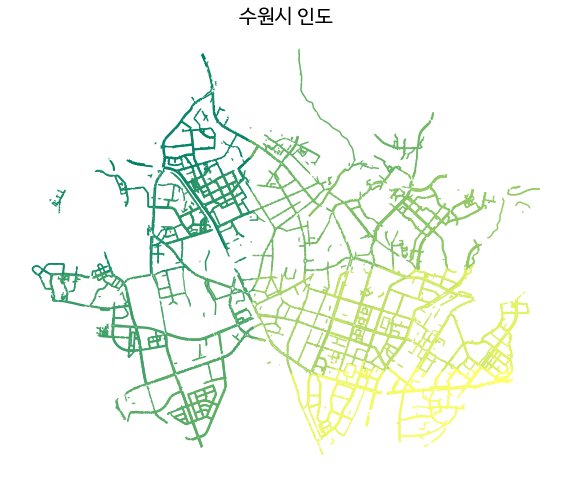

In [ ]:
gpdplot(df_인도26, "UFID", title="수원시 인도", cmap='summer', figsize=(10, 10))

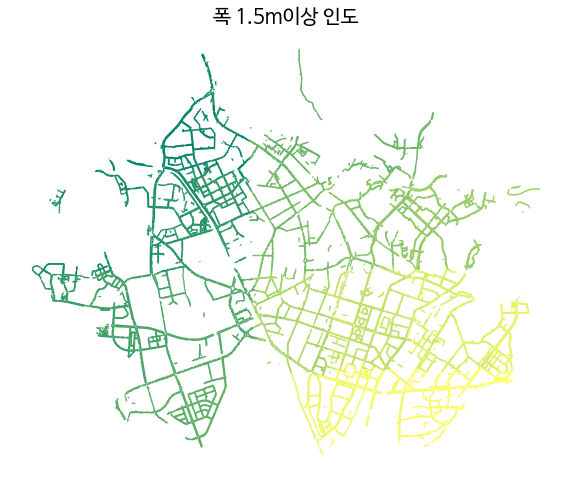

In [ ]:
gpdplot(df_가능인도, "UFID", title="폭 1.5m이상 인도", cmap='summer', figsize=(10, 10))

In [ ]:
gpdplot(df_연면적28, 'gid', '건물연면적', figsize=(10, 10))

In [ ]:
df_list  = [df_교통노드20, df_도로명27, df_지적도32, df_상세도로망22] #, df_교통링크21
df_ids   = ['NODE_ID', 'BDTYP_CD', 'PNU', 'link_id'] #, 'LINK_ID'
df_title = ['교통노드', '도로명', '지적도', '상세도로망'] #, '교통링크'

gpdplot(df_list, df_ids, title=df_title, sub=True, nrow=2, ncol=2, figsize=(15, 15))

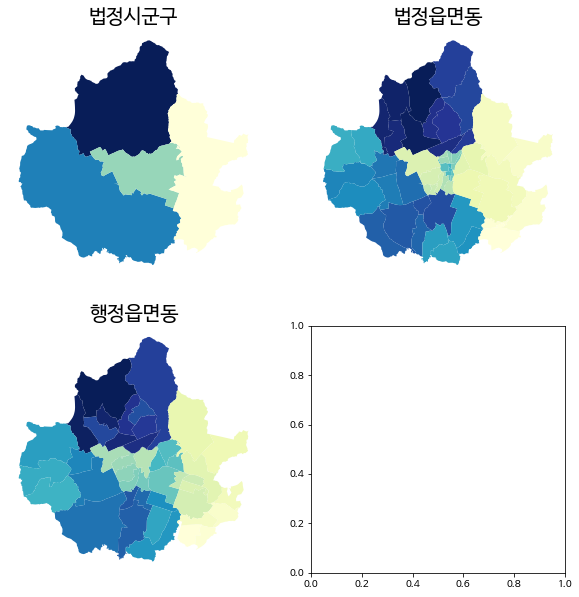

In [ ]:
df_구역나눔_list  = [df_법정시군구29, df_법정읍면동30, df_행정읍면동31]
df_구역나눔_id    = ["SIG_CD", "EMD_CD", "ADM_DR_CD"]
df_구역나눔_title = ['법정시군구', '법정읍면동', '행정읍면동']

gpdplot(df_구역나눔_list, df_구역나눔_id, title=df_구역나눔_title, sub=True, nrow=2, ncol=2, figsize=(10, 10))

In [ ]:
# df_popul['geometry1'] = df_popul['geometry']
# df_popul['geometry'] = df_popul['geo_cent']

In [ ]:
# df_popul.head()

In [ ]:
df_popul.describe()

,val,정규화
count,37500.000000,37500.000000
mean,31.574933,0.014707
std,92.760756,0.043205
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,13.000000,0.006055
max,2147.000000,1.000000


In [ ]:
df_popul["val"].sort_values(ascending=False)

8460     2147.0
11525    1791.0
11194    1498.0
11102    1426.0
11280    1187.0
          ...  
11183       0.0
11184       0.0
11185       0.0
11186       0.0
0           0.0
Name: val, Length: 37500, dtype: float64

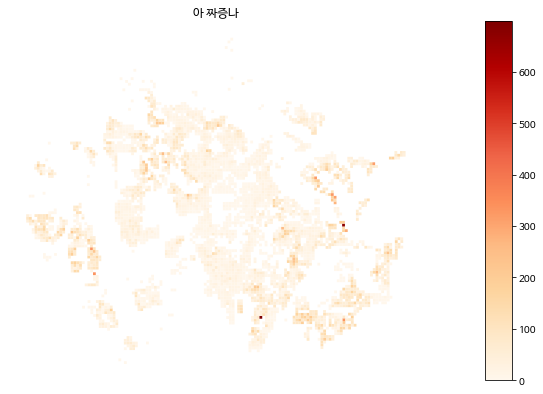

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# 수원 시군구 인구 분포 단계구분도(Chropleth Map) 시각화
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# 범례
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
# 시각화
column = 'val'
df_popul[df_popul['label'] == '유소년'].plot(column, ax=ax, legend=True, cax=cax, cmap='OrRd')
ax.set_title("아 짜증나")
ax.set_axis_off()
plt.show()

In [ ]:
df_행정읍면동31.head()

,ADM_DR_CD,ADM_DR_NM,geometry,coord_cent,geo_cent,grid_id
0,3101154,파장동,"MULTIPOLYGON (((127.00491 37.33910, 127.00535 ...","[126.98937797965233, 37.3205314950593]",POINT (126.9893779796523 37.3205314950593),00000
1,3101155,율천동,"MULTIPOLYGON (((126.97444 37.30857, 126.97466 ...","[126.97175291590135, 37.2995923755296]",POINT (126.9717529159013 37.2995923755296),00001
2,3101156,정자1동,"MULTIPOLYGON (((126.98764 37.31051, 126.98754 ...","[126.98932233822585, 37.30470343890576]",POINT (126.9893223382258 37.30470343890576),00002
3,3101157,정자2동,"MULTIPOLYGON (((126.99806 37.29766, 126.99830 ...","[126.99838339827063, 37.292270984058746]",POINT (126.9983833982706 37.29227098405875),00003
4,3101159,송죽동,"MULTIPOLYGON (((127.01135 37.31892, 127.01146 ...","[127.00480729486611, 37.30643530010377]",POINT (127.0048072948661 37.30643530010377),00004


In [ ]:
sigungu = 행정경계시군구.copy()
dong = 고양시행정경계행정동기준.copy()
sigungu['coordinates'] = sigungu['geometry'].apply(multipolygon_to_coordinates) 
sigungu = pd.DataFrame(sigungu)

dong['coordinates'] = dong['geometry'].apply(multipolygon_to_coordinates) 
dong = pd.DataFrame(dong)
dong['adm_nm'] = dong['행정동명']

In [ ]:
df_행정읍면동31['coord_cent'][0][0]

126.98937797965233

In [ ]:
# def get_point_isin_which_dong(Data_point_input, Data_dong_input, target):
#     Data_point = Data_point_input.copy()
#     Data_dong  = Data_dong_input.copy()
    
#     dong_contain = []
#     index = []
    
#     for i in tqdm(range(0, len(Data_point))):
#         for idx, coord in enumerate(Data_dong['geometry']):
            
#             if coord.contains(Point(Data_point[['경도','위도']].values[i])):
#                 dong_contain.append(Data_dong.loc[idx, target])           
#                 index.append(i)
                
#     return dong_contain, index

In [ ]:
# Data_point = df_popul
# Data_dong  = df_행정읍면동31

# dong_contain = []
# index = []

# for i in tqdm(range(0, len(Data_point))):
#     for idx, coord in enumerate(Data_dong['geometry']):
#         if coord.contains(Data_point[['coord_cent'][1], ['coord_cent'][0]].values[i]):
#             dong_contain.append(Data_dong.loc[idx, 'val'])           
#             index.append(i)

In [ ]:
# # 인구분포도 = 인구분포도[인구분포도['val'] != 0].reset_index(drop=True)
# df_popul = df_popul[df_popul['val'] != 0].reset_index(drop=True)

# print(len(df_popul))
# adm_nm, idx = get_point_isin_which_dong(df_popul, dong, 'adm_nm')

# # 인구분포도 = 인구분포도[인구분포도.index.isin(idx)]
# # 인구분포도['adm_nm'] = adm_nm
# df_popul = df_popul[df_popul.index.isin(idx)]
# df_popul['adm_nm'] = adm_nm

### 시각화 - pydeck ; Colab 작동 X(jupyter에서 사용)

In [ ]:
# pydeck은 Colab 지원 X -> Jupyter notebook 사용
# https://compas.lh.or.kr/subj/past/code?subjNo=SBJ_2009_001&teamNo=677
# 광양시 전기자동차 충전소
# Make layer
# 사람이 있는 그리드만 추출
layer = pdk.Layer( 'PolygonLayer', # 사용할 Layer 타입 
                  df_popul[(df_popul['val'].isnull()==False) & df_popul['val']!=0], # 시각화에 쓰일 데이터프레임 
                  get_polygon='coordinates', # geometry 정보를 담고있는 컬럼 이름 
                  get_fill_color='[0, 255*정규화인구, 0, 정규화인구*10000 ]', # 각 데이터 별 rgb 또는 rgba 값 (0~255)
                  pickable=True, # 지도와 interactive 한 동작 on 
                  auto_highlight=True # 마우스 오버(hover) 시 박스 출력 
                 ) 

# Set the viewport location 
center = [127.696280, 34.940640] 
view_state = pdk.ViewState( 
    longitude=center[0], 
    latitude=center[1], 
    zoom=10
) 

# Render 
r = pdk.Deck(layers=[layer], 
             initial_view_state=view_state,
             map_style='mapbox://styles/mapbox/dark-v9', 
             api_keys='pk.eyJ1IjoianVuZ3dvbjY0MiIsImEiOiJja2x0aHYwc3UwM2hpMm5uNjF2cnRxMmlyIn0.f795wWCq-p1kAZBvoZL2Ww'
            #  map_style='mapbox://styles/mapbox/outdoors-v11'
            )
# r = pdk.Deck(layers=[layer], initial_view_state=view_state)
# r.to_html()

r.show()

### 시각화 - folium; CircularBinning으로 json, to_crs, to_json

In [ ]:
json = CircularBinning(features="geoband:gvi_busan", weight="greenview",
                        csr="EPSG:4326", minX="128.7617", minY="34.9891", maxX="129.3056", maxY="35.389",
                        radius="0.05", validGrid="False", saveFileName="json/result_CircularBinning.json")
gdf = gpd.read_file('json/result_CircularBinning.json')

In [ ]:
gdf = gdf.to_crs(epsg='4326')
converted_json = gdf.to_json()

m = folium.Map(
    location=[35.1598,129.0001],
    zoom_start=10
)

folium.GeoJson(
    converted_json,
).add_to(m)

m